[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RadimKozl/JLNN/blob/main/examples/real_world_data_iris.ipynb)

## **Model explanation:**
This model uses JLNN (JAX Logic Neural Network) to find the optimal logical description of the class Iris Setosa. Unlike classical neural networks, the result is learned boundaries ("what is a big leaf") and logical weights ("which leaf is essential for determining the species"). The model is interpretable - after training, we can tell exactly what rule the model uses for classification.

## **Iris Dataset:**

The dataset contains 150 samples of three iris species (Setosa, Versicolor, Virginica). For each sample, we have 4 properties: length and width of sepals and corolla petals. Setosa is linearly separable from the other two species, making it an ideal target for a logical rule.

## **What the model learns:**

The model learns a neuro-symbolic representation of the rule: *"If the flower is small (short and narrow), then it is an Iris Setosa."*

- **Predicates:** The model transforms real numbers (centimeters) into truth values ​​(intervals $[L,U]$) using learned sigmoidal functions.
- **Weighted logic:** Using weights $\mathcal{w}\geq1$, the model determines which attribute is more important for the definition of Setosa.
- **Goal:** Minimize the correspondence between the logical statement and the actual label (ground truth).

## **1. Installation and automatic restart**

In [ ]:
try:
    import jlnn
    from flax import nnx
    import jax.numpy as jnp
    print("✅ JLNN and JAX are ready.")
except ImportError:
    print("🚀 Installing JLNN from GitHub and fixing JAX for Colab...")
    # Instalace frameworku
    #!pip install jax-lnn --quiet
    !pip install git+https://github.com/RadimKozl/JLNN.git --quiet
    !pip install scikit-learn netCDF4 --quiet
    # Fix JAX/CUDA compatibility for 2026 in Colab
    !pip install --upgrade "jax[cuda12_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

    import os
    print("\n🔄 RESTARTING ENVIRONMENT... Please wait a second and then run the cell again.")
    os.kill(os.getpid(), 9)
    os.kill(os.getpid(), 9) # After this line, the cell stops and the environment restarts

🚀 Installing JLNN from GitHub and fixing JAX for Colab...
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.0/488.0 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 64.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 74.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 68.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.5/17.5 MB 68.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 73.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 915.7/915.7 MB

#### ***Library imports***

In [1]:
import jax
import jax.numpy as jnp
import numpy as np
from flax import nnx
import optax
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score, confusion_matrix

from jlnn.symbolic.compiler import LNNFormula
from jlnn.nn.constraints import apply_constraints
from jlnn.training.losses import total_lnn_loss
from jlnn.utils.xarray_utils import model_to_xarray, extract_weights_to_xarray

## **2. Data preparation**

In [2]:
iris = load_iris()
X, y = iris.data, iris.target
# Normalization for logical operations
X_norm = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0) + 1e-6)

## **3. Fuzzy Grounding (Fuzzification)**
We define expert sigmoid ramps

In [3]:
def fuzzy_ramp(x, center, steepness=10):
    l = 1 / (1 + jnp.exp(-steepness * (x - (center + 0.1))))
    u = 1 / (1 + jnp.exp(-steepness * (x - (center - 0.1))))
    return jnp.stack([l, u], axis=-1)

Example: Petal Length (index 2) and Petal Width (index 3)

In [4]:
high_length = fuzzy_ramp(X_norm[:, 2], center=0.6)
high_width  = fuzzy_ramp(X_norm[:, 3], center=0.5)

1. Setosa as an input predicate (for implication purposes) <br>
It must be (150, 2) and JAX prefers float32

In [5]:
unknown_setosa = jnp.ones((len(y), 2), dtype=jnp.float32)
unknown_setosa = unknown_setosa.at[:, 0].set(0.0) # L=0
unknown_setosa = unknown_setosa.at[:, 1].set(1.0) # U=1

2. Adjusting the target for the loss function <br>
total_lnn_loss expects (batch, 2) or (batch, 1) depending on the version,<br>
but for the classification of Setosa, we want the target interval [1, 1] for Setosa and [0, 0] for the others.

In [6]:
target_interval = jnp.where(
    (y == 0)[:, None],
    jnp.array([[0.9, 1.0]]),
    jnp.array([[0.0, 0.1]])
)

3. Updating the inputs dictionary

In [7]:
inputs = {
    "high_length": high_length,
    "high_width": high_width
}

## **4. Model & Expert Rules**
"If both the length and width of the petal are large, then it is NOT Setosa (class 0)" <br>
To simplify, let's try the rule for Setosa: "Small length & Small width -> Setosa"

In [8]:
formula = "0.9::(~high_length & ~high_width)"
model = LNNFormula(formula, nnx.Rngs(42))

## **5. Hybridy Training**

In [9]:
optimizer = nnx.Optimizer(model, optax.adam(0.02), wrt=nnx.Param)
target = (y == 0).astype(jnp.float32)[:, None]

In [10]:
@nnx.jit
def train_step(model, optimizer, inputs, target):
    def loss_fn(m):
        pred = m(inputs)
        # If pred returns (150, 2, 2), we reduce the gate dimension to (150, 2)
        if pred.ndim == 3:
            pred = jnp.min(pred, axis=1)
        return total_lnn_loss(pred, target)

    loss, grads = nnx.value_and_grad(loss_fn)(model)
    optimizer.update(model, grads)
    apply_constraints(model)
    return loss

In [11]:
print("🚀 I'm training a hybrid model (Expert + Data)...")

🚀 I'm training a hybrid model (Expert + Data)...


In [12]:
# Starting a workout
for step in range(101):
    loss = train_step(model, optimizer, inputs, target_interval)
    if step % 25 == 0:
        print(f"Step {step:3d} | Loss: {loss:.6f}")

Step   0 | Loss: 0.305000
Step  25 | Loss: 0.305000
Step  50 | Loss: 0.305000
Step  75 | Loss: 0.305000
Step 100 | Loss: 0.305000


In [13]:
print("✅ Training ended")

✅ Training ended


## **6. Evaluation**

In [14]:
preds = model(inputs)

In [15]:
# Safety print – confirm shape
print("preds shape:", preds.shape)

preds shape: (150, 2, 2)


In [16]:
# Reduce
preds_reduced = jnp.min(preds, axis=1)  # (150, 2)
# preds_reduced = jnp.max(preds, axis=1)   # alternative
# preds_reduced = jnp.mean(preds, axis=1)

In [17]:
# Now safe to use
acc = jnp.mean((preds_reduced[:, 0] > 0.5) == (y == 0))
print(f"Accuracy: {float(acc):.3f} ({float(acc)*100:.1f}%)")

Accuracy: 0.667 (66.7%)


In [18]:
# sklearn version (if you prefer)
acc_sk = accuracy_score(
    (y == 0).astype(int),
    (preds_reduced[:, 0] > 0.5).astype(int)
)
print(f"sklearn acc: {acc_sk:.3f}")

sklearn acc: 0.667


In [19]:
# Uncertainty
widths = preds_reduced[:, 1] - preds_reduced[:, 0]

In [20]:
print(f"\n✅ Results:")
print(f"Accuracy: {acc:.2%}")
print(f"Average uncertainty (U-L): {float(widths.mean()):.4f}")


✅ Results:
Accuracy: 66.67%
Average uncertainty (U-L): 0.0000


## **7. Xarray Integration & Weight Visualization**

#### Dynamic search for a gateway for extracting weights

In [21]:
# Assuming your formula has one main conjunction (~high_length & ~high_width)
# Try to extract directly — the function is designed for this

da_weights = extract_weights_to_xarray(
    weights=model,  # pass the whole model if it accepts it
    input_labels=["~high_length", "~high_width"],   # or ["not_high_length", "not_high_width"]
    gate_name="conjunction"   # try common names; may need experimentation
)
da_weights

<xarray.DataArray 'weights_conjunction' (input: 2)> Size: 16B
array([LNNFormula( # Param: 13 (52 B)
         predicates=Dict({
           'high_length': PredicateNode( # Param: 4 (16 B)
             name='high_length',
             predicate=LearnedPredicate( # Param: 4 (16 B)
               offset_l=Param( # 1 (4 B)
                 value=Array([0.], dtype=float32)
               ),
               offset_u=Param( # 1 (4 B)
                 value=Array([-0.2], dtype=float32)
               ),
               slope_l=Param( # 1 (4 B)
                 value=Array([1.], dtype=float32)
               ),
               slope_u=Param( # 1 (4 B)
                 value=Array([1.], dtype=float32)
               )
             )
           ),
           'high_width': PredicateNode( # Param: 4 (16 B)
...
             UnaryGateNode( # Param: 1 (4 B)
               child=PredicateNode(...),
               gate=WeightedNot( # Param: 1 (4 B)
                 weight=Param( # 1 (4 B)
                   value=Array(1., dtype=float32)
                 )
               )
             )
           ]),
           gate=WeightedAnd( # Param: 3 (12 B)
             beta=Param( # 1 (4 B)
               value=Array(1., dtype=float32)
             ),
             weights=Param( # 2 (8 B)
               value=Array(shape=(2,), dtype=dtype('float32'))
             )
           )
         )
       )                                                      ],
      dtype=object)
Coordinates:
  * input    (input) <U12 96B '~high_length' '~high_width'

In [22]:
# Right after preds = model(inputs)
print("Original preds shape:", preds.shape)  # confirms (150, 2, 2)

Original preds shape: (150, 2, 2)


In [23]:
# Reduce to one [L,U] per sample
preds_agg = jnp.min(preds, axis=1)           # → (150, 2)
# Alternatives you can try:
# preds_agg = jnp.max(preds, axis=1)         # optimistic
# preds_agg = jnp.mean(preds, axis=1)        # average

print("Aggregated shape:", preds_agg.shape)  # should be (150, 2)

Aggregated shape: (150, 2)


#### Convert outputs to Dataset

In [24]:
ds = model_to_xarray(
    gate_outputs={"setosa_prediction": preds_agg},
    sample_labels=[f"iris_{i}" for i in range(len(y))]
)
ds

<xarray.Dataset> Size: 6kB
Dimensions:            (sample: 150, bound: 2)
Coordinates:
  * sample             (sample) <U8 5kB 'iris_0' 'iris_1' ... 'iris_149'
  * bound              (bound) <U5 40B 'Lower' 'Upper'
Data variables:
    setosa_prediction  (sample, bound) float32 1kB ...

## **8. Visualization**

#### ***1. We get the state and safely extract the value of the weights***

In [25]:
graphdef, state = nnx.split(model)
state_dict = state.to_dict() if hasattr(state, 'to_dict') else dict(state)
weights_var = state_dict['root']['gate']['weights']

We use .get_value() or [...] to remove the warning

In [26]:
if hasattr(weights_var, 'get_value'):
    conj_weights = weights_var.get_value()
else:
    conj_weights = weights_var[...]

#### ***2. Visualization itself***

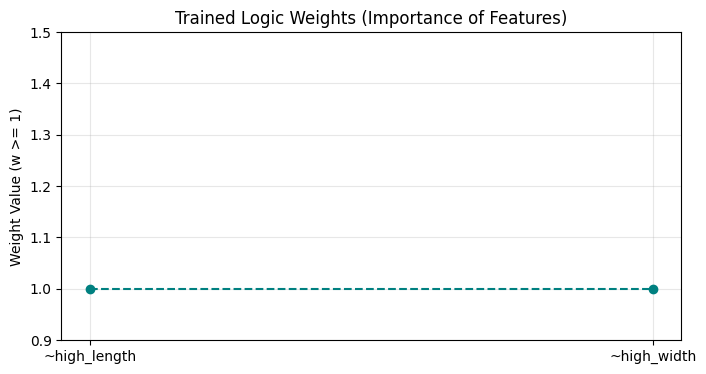

In [27]:
plt.figure(figsize=(8, 4))

labels = ["~high_length", "~high_width"]
values = [float(w) for w in conj_weights.flatten()]

plt.plot(labels, values, marker='o', linestyle='--', color='teal', linewidth=1.5)
plt.title("Trained Logic Weights (Importance of Features)")
plt.ylabel("Weight Value (w >= 1)")
plt.ylim(0.9, max(values) + 0.5)
plt.grid(True, alpha=0.3)
plt.show()